In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json
import numpy 
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import pyarrow
import sys

from datetime import date
from dotenv import load_dotenv
from sqlalchemy import create_engine
from os import path
from typing import List,Dict, Tuple
from collections import defaultdict
pd.set_option("display.max_columns", None)

load_dotenv(verbose=True)
BIGQUERY_CREDENTIALS_PATH = os.environ.get('BIGQUERY_CREDENTIALS_PATH')
engine = create_engine('bigquery://bespoke-financial/ProdMetrcData', credentials_path=os.path.expanduser(BIGQUERY_CREDENTIALS_PATH))

sys.path.append(path.realpath(path.join(os.getcwd(), "../core")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../src")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../scripts")))

import create_queries
import prepare_data

from bespoke.inventory.analysis.shared import download_util, inventory_types
from bespoke.inventory.analysis import active_inventory_util as util
from bespoke.inventory.analysis import inventory_valuations_util as valuations_util

%load_ext autoreload
%autoreload 2

In [52]:
cb_quarter = pd.read_csv('cb_quarter_0615.csv')
cb_hounce = pd.read_csv('cb_hounce_0615.csv')
cb_ounce = pd.read_csv('cb_ounce_0615.csv')
cb_8 = pd.read_csv('cb_eighth_0615.csv')

In [53]:
cb_quarter['create_month'] = pd.to_datetime(cb_quarter['create_month'])
cb_hounce['create_month'] = pd.to_datetime(cb_hounce['create_month'])
cb_ounce['create_month'] = pd.to_datetime(cb_ounce['create_month'])
cb_8['create_month'] = pd.to_datetime(cb_8['create_month'])

cb_quarter['create_month'] = [cb_quarter['create_month'][i].replace(day=1) for i in range(len(cb_quarter))]
cb_hounce['create_month'] = [cb_hounce['create_month'][i].replace(day=1) for i in range(len(cb_hounce))]
cb_ounce['create_month'] = [cb_ounce['create_month'][i].replace(day=1) for i in range(len(cb_ounce))]
cb_8['create_month'] = [cb_8['create_month'][i].replace(day=1) for i in range(len(cb_8))]

In [57]:
cb_8 = cb_8[cb_8['name'] != 'claybourne co. 3.5g'] # noisy data


In [39]:
#cb_quarter[['create_month','change_perc']].groupby(['create_month']).describe()

In [40]:
#cb_hounce[['create_month','change_perc']].groupby(['create_month']).describe()

In [41]:
#cb_ounce[['create_month','change_perc']].groupby(['create_month']).describe()

In [47]:
import seaborn as sns; sns.set()
sns.set(rc={'figure.figsize':(10,5)})

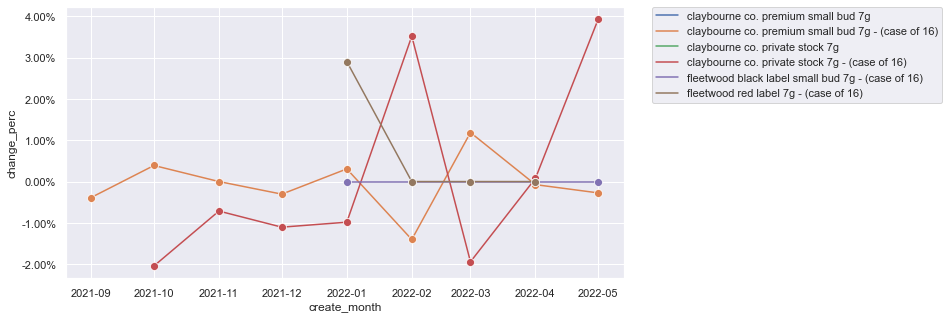

In [49]:
ax=sns.lineplot(x="create_month", y="change_perc", hue="name", data=cb_quarter[cb_quarter['sum'] > 50],marker='o',markersize=8)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
vals = ax.get_yticks()
a = ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

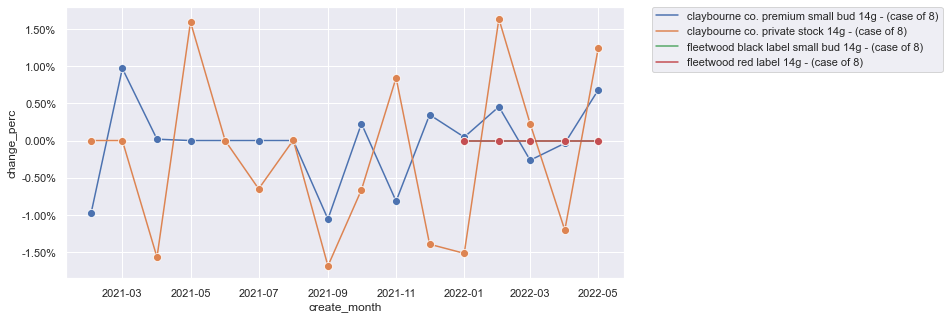

In [50]:
ax=sns.lineplot(x="create_month", y="change_perc", hue="name", data=cb_hounce[cb_hounce['sum'] > 50],marker='o',markersize=8)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
vals = ax.get_yticks()
a = ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

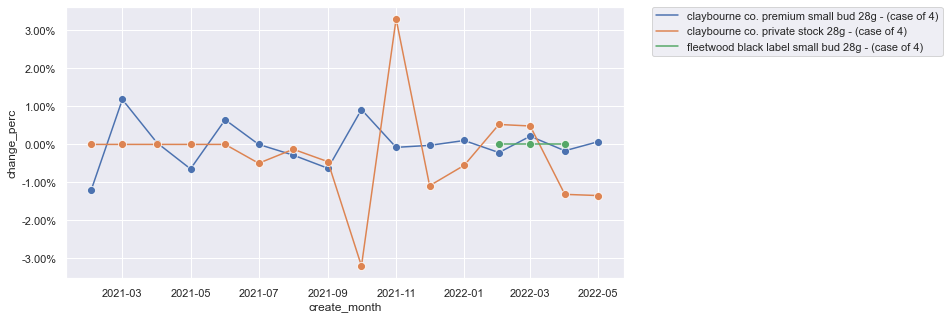

In [51]:
ax=sns.lineplot(x="create_month", y="change_perc", hue="name", data=cb_ounce[cb_ounce['sum'] > 50],marker='o',markersize=8)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
vals = ax.get_yticks()
a = ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

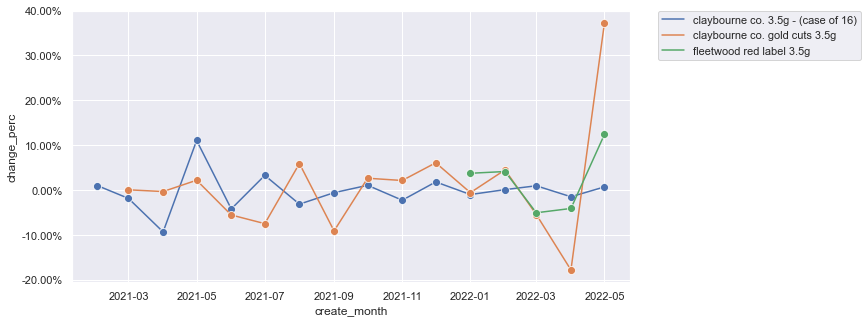

In [58]:
ax=sns.lineplot(x="create_month", y="change_perc", hue="name", data=cb_8[cb_8['sum'] > 50],marker='o',markersize=8)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
vals = ax.get_yticks()
a = ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

In [ ]:
"""
-- clay born matrix
with base as (
    select case
               when company_deliveries.delivery_type = 'INCOMING_UNKNOWN' then 'INCOMING_FROM_VENDOR'
               when company_deliveries.delivery_type = 'INCOMING_FROM_VENDOR' then 'INCOMING_FROM_VENDOR'
               when company_deliveries.delivery_type = 'OUTGOING_UNKNOWN' then 'OUTGOING_TO_PAYOR'
               when company_deliveries.delivery_type = 'OUTGOING_TO_PAYOR' then 'OUTGOING_TO_PAYOR'
               else company_deliveries.delivery_type
               end                                                                 as delivery_type,
           company_deliveries.license_number,
           metrc_transfers.created_date,
           last_day(metrc_transfers.created_date) create_month,
           metrc_transfers.shipper_facility_license_number,
           metrc_transfers.shipper_facility_name,
           metrc_deliveries.recipient_facility_license_number,
           metrc_deliveries.recipient_facility_name,
           metrc_deliveries.shipment_type_name,
           metrc_deliveries.shipment_transaction_type,
           metrc_transfer_packages.package_id,
           metrc_transfer_packages.package_label,
           metrc_transfer_packages.product_category_name,
           metrc_transfer_packages.product_name,
           metrc_transfer_packages.shipper_wholesale_price,
           metrc_transfer_packages.shipped_quantity,
           metrc_transfer_packages.shipper_wholesale_price /
           nullif(metrc_transfer_packages.shipped_quantity, 0)                        tx_price_per_unit,
           metrc_transfer_packages.shipped_unit_of_measure,
           metrc_transfer_packages.package_payload.receiverwholesaleprice          as receiver_wholesale_price,
           metrc_transfer_packages.received_quantity,
           metrc_transfer_packages.received_unit_of_measure,
           metrc_transfer_packages.package_payload.receiverwholesaleprice          as receiver_wholesale_price,
           metrc_transfer_packages.package_payload.itemunitweight                  as item_unit_weight,
           metrc_transfer_packages.package_payload.itemunitweightunitofmeasurename as item_unit_weight_unit_of_measure_name
    from `bespoke-financial`.ProdMetrcData.metrc_transfers metrc_transfers
             inner join `bespoke-financial`.ProdMetrcData.company_deliveries company_deliveries
                        on metrc_transfers.id = company_deliveries.transfer_row_id
             inner join `bespoke-financial`.ProdMetrcData.companies companies
                        on company_deliveries.company_id = companies.id
             inner join `bespoke-financial`.ProdMetrcData.metrc_deliveries metrc_deliveries
                        on metrc_transfers.id = metrc_deliveries.transfer_row_id
             inner join `bespoke-financial`.ProdMetrcData.metrc_transfer_packages metrc_transfer_packages
                        on metrc_deliveries.id = metrc_transfer_packages.delivery_row_id
    where True
      and companies.identifier in ('CI')

      and (
                company_deliveries.delivery_type = 'OUTGOING_TO_PAYOR' or
                company_deliveries.delivery_type = 'OUTGOING_INTERNAL' or
                company_deliveries.delivery_type = 'OUTGOING_UNKNOWN'
        )
      and metrc_transfers.created_date >= "2021-01-01"
    and product_category_name = 'Flower (packaged eighth - each)'
),
base_with_name as (
select *,
       /*
case when lower(product_name) like '%claybourne co. premium small bud 28g - (case of 4)%' then 'claybourne co. premium small bud 28g - (case of 4)'
     when lower(product_name) like '%claybourne co. premium small bud 28g%' then 'claybourne co. premium small bud 28g'
when lower(product_name) like '%claybourne co. private stock 28g - (case of 4)%' then 'claybourne co. private stock 28g - (case of 4)'
when lower(product_name) like '%claybourne co. private stock 28g%' then 'claybourne co. private stock 28g'
when lower(product_name) like '%fleetwood black label small bud 28g - (case of 4)%' then 'fleetwood black label small bud 28g - (case of 4)'
when lower(product_name) like '%fleetwood red label 28g - (case of 4)%' then 'fleetwood red label 28g - (case of 4)'
else null end as name

        */
case when lower(product_name) like '%claybourne co. 3.5g - (case of 16)%' then 'claybourne co. 3.5g - (case of 16)'
     when lower(product_name) like '%claybourne co. 3.5g%' then 'claybourne co. 3.5g'
when lower(product_name) like '%claybourne co. gold cuts 3.5g%' then 'claybourne co. gold cuts 3.5g'
when lower(product_name) like '%fleetwood red label 3.5g%' then 'fleetwood red label 3.5g'
else null end as name
from base
where shipper_wholesale_price > 1
)
,

trend as (
    select create_month,
           name,
           count(*)               count,
           sum(shipped_quantity)sum,
           AVG(tx_price_per_unit) avg_price_per_unit
    from base_with_name

    group by 1,2
    order by 2,1
),
trend_with_change as (
    select *,
           lag(avg_price_per_unit, 1) over (partition by name order by create_month) lag_avg_price_per_unit,
           (avg_price_per_unit - lag(avg_price_per_unit, 1) over (partition by name order by create_month)) /
           lag(avg_price_per_unit, 1) over (partition by name order by create_month) change_perc
    from trend
)
select * from trend_with_change
where create_month < '2022-06-30'
and name is not null
and change_perc is not null
order by name, create_month


"""